In [168]:
!pip install lightgbm  # If not already installed

import lightgbm as lgb
from sklearn.metrics import mean_pinball_loss
import pandas as pd # Import pandas if not already imported for to_timedelta

# Function to convert duration string to seconds
def duration_to_seconds(duration_str):
    if pd.isna(duration_str):
        return None
    try:
        # Handle cases with days if necessary, but assuming HH:MM:SS format from sample
        parts = str(duration_str).split(':')
        if len(parts) == 3:
            h, m, s = map(int, parts)
            return h * 3600 + m * 60 + s
        elif len(parts) == 2: # Handle MM:SS if any exist
             m, s = map(int, parts)
             return m * 60 + s
        else: # Handle just seconds if any exist
            return int(parts[0])
    except ValueError:
        return None # Return None for unparseable strings


# Convert 'duration' column to numeric (seconds)
X_train['duration'] = X_train['duration'].apply(duration_to_seconds)
X_test['duration'] = X_test['duration'].apply(duration_to_seconds)

# Prepare data (using your existing X_train/y_train)
# Handle potential NaNs introduced by conversion if any
X_train['duration'].fillna(X_train['duration'].median(), inplace=True)
X_test['duration'].fillna(X_test['duration'].median(), inplace=True)


train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Quantiles to predict (e.g., 10th, 50th, 90th percentiles)
quantiles = [0.1, 0.5, 0.9]
models = {}

for q in quantiles:
    print(f"\nTraining quantile: {q}")
    params = {
        'objective': 'quantile',
        'alpha': q,
        'metric': 'quantile',
        'boosting_type': 'gbdt',
        'max_depth': 7,
        'learning_rate': 0.05,
        'n_estimators': 300, # n_estimators is typically for the sklearn API; for the native API, boosting_rounds is used
        'num_boost_round': 300, # Use num_boost_round for native API
        'min_data_in_leaf': 20,
        'reg_alpha': 1.0,
        'reg_lambda': 1.0
    }

    # Define early stopping callback
    early_stopping_callback = lgb.early_stopping(stopping_rounds=50, verbose=True)

    models[q] = lgb.train(
        params,
        train_data,
        valid_sets=[test_data],
        num_boost_round=params['num_boost_round'], # Pass num_boost_round
        callbacks=[early_stopping_callback] # Use callbacks parameter
    )

    # Evaluate
    y_pred = models[q].predict(X_test)
    print(f"Pinball loss (@{q}): {mean_pinball_loss(y_test, y_pred, alpha=q):.4f}")


Training quantile: 0.1
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=7) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=128) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=7) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=128) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.312136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4939
[LightGBM] [Info] Number of data

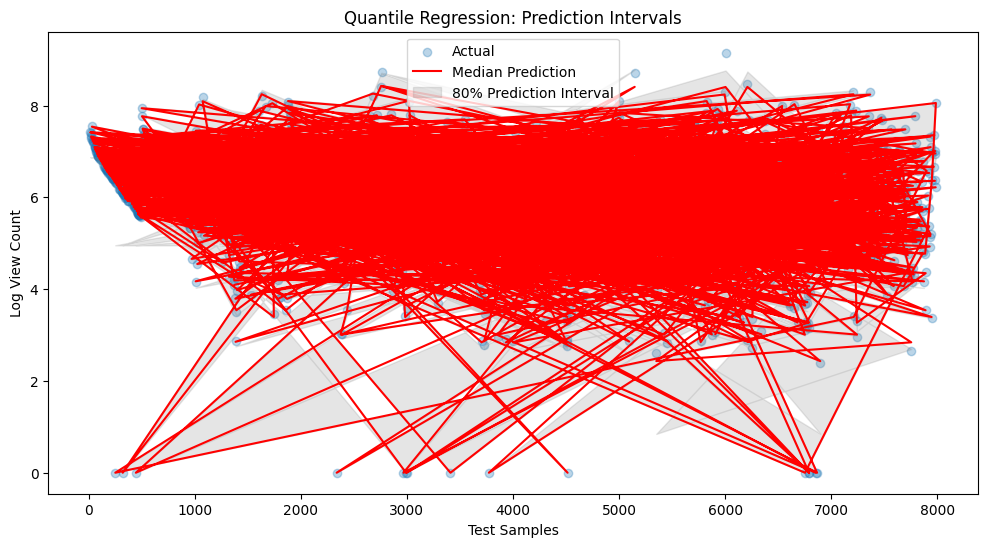

In [169]:
# Generate predictions for all quantiles
predictions = pd.DataFrame({
    'actual': y_test,
    'q10': models[0.1].predict(X_test),
    'median': models[0.5].predict(X_test),
    'q90': models[0.9].predict(X_test)
})

# Plot prediction intervals
plt.figure(figsize=(12, 6))
plt.scatter(predictions.index, predictions['actual'], alpha=0.3, label='Actual')
plt.plot(predictions.index, predictions['median'], color='red', label='Median Prediction')
plt.fill_between(
    predictions.index,
    predictions['q10'],
    predictions['q90'],
    color='gray',
    alpha=0.2,
    label='80% Prediction Interval'
)
plt.xlabel('Test Samples')
plt.ylabel('Log View Count')
plt.title('Quantile Regression: Prediction Intervals')
plt.legend()
plt.show()

In [170]:
def evaluate_intervals(y_true, y_lower, y_upper):
    """Calculate coverage and interval width"""
    coverage = np.mean((y_true >= y_lower) & (y_true <= y_upper))
    avg_width = np.mean(y_upper - y_lower)
    return coverage, avg_width

coverage, width = evaluate_intervals(
    y_test,
    models[0.1].predict(X_test),
    models[0.9].predict(X_test)
)

print(f"\nBusiness Metrics:")
print(f"80% Prediction Interval Coverage: {coverage*100:.1f}%")
print(f"Average Interval Width: {width:.2f} log units")
print(f"  → Translates to {10**width:.1f}x view count range")


Business Metrics:
80% Prediction Interval Coverage: 72.5%
Average Interval Width: 0.29 log units
  → Translates to 1.9x view count range


In [173]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np # Import numpy for isna

# Identify categorical columns in X_train that are objects or categories
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

# Create a column transformer for one-hot encoding categorical features
# Handle potential NaNs in categorical columns before encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Impute missing categorical values
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Handle unknown categories during transformation
])

# Create a preprocessor that applies one-hot encoding to categorical columns
# No transformation needed for numeric columns as they are already handled for LightGBM
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough' # Keep numeric columns as they are
)

# Create a pipeline for the RandomForestRegressor including preprocessing
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor_rf),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])


# Train the RandomForestRegressor pipeline
# The pipeline will handle preprocessing (one-hot encoding) before fitting the model
pipeline_rf.fit(X_train, y_train)

# Get point estimates from the trained RandomForest pipeline
rf_pred = pipeline_rf.predict(X_test)

# Blend with quantile intervals from LightGBM models
# Ensure X_test used for LightGBM predictions is the preprocessed version
# from the cell QfkZGIl8seeK that successfully trained the LightGBM models.
# Assuming X_test in the current scope is the correct preprocessed version
# that was used for the LightGBM models.

final_pred = pd.DataFrame({
    'point_estimate': rf_pred,
    'lower_bound': models[0.1].predict(X_test),
    'upper_bound': models[0.9].predict(X_test),
    'actual': y_test
})

# Calculate improved metrics
final_pred['within_bounds'] = (final_pred['actual'] >= final_pred['lower_bound']) & \
                             (final_pred['actual'] <= final_pred['upper_bound'])
print(f"\nHybrid Model Coverage: {final_pred['within_bounds'].mean()*100:.1f}%")

# You might also want to evaluate other metrics for the point estimate model alone
# print("\nRandomForest Point Estimate Model Performance:")
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# print(f"MAE: {mean_absolute_error(y_test, rf_pred):.4f}")
# print(f"RMSE: {np.sqrt(mean_squared_error(y_test, rf_pred)):.4f}")
# print(f"R²: {r2_score(y_test, rf_pred):.4f}")


Hybrid Model Coverage: 72.5%
